# Kats 101 - Basics

Kats (**K**its to **A**nalyze **T**ime **S**eries) is a light-weight, easy-to-use, extenable, and generalizable framework to perform time series analysis in Python.  Time series analysis is an essential component of data science and engineering work.  Kats aims to provide a one-stop shop for techniques for univariate and multivariate time series including:
- Forecasting trends
- Change-point detection
- Anomaly detection
- Feature Extraction


We provide two types of tutorial notebooks
- **Kats 101**, basic data structure and functionalities in Kats (this tutorial)  
- **Kats 20x**, advanced topics, such as advanced forecasting techniques (meta-learning, global model, etc.), advanced detection algorithms (Bayesian online change point detection algorithms, etc), and more.

This Kats 101 notebook provides basic tutorials of Kats for beginners in time series analysis domain, the table of contents is listed as follows. 
* 1. Kats Basics
    - 1.1 Initiate `TimeSeriesData` Object
    - 1.2 `TimeSeriesData` built-in operations
* 2. Forecasting with Kats
    - 2.1 An example with Prophet model
    - 2.2 An example with Theta model
* 3. Detection with Kats
    - 3.1 What are the algorithms?
    - 3.2 An example with outlier detection method
    - 3.3 An example with CUSUM algorithm
* 4. Feature extraction with Kats
* 5. Summary

# 1. Kats Basics
`TimeSeriesData` is the basic data structure in Kats to represented univariate and multivariate time series.  There are two ways to initiate it, henceforth referred to as "Method 1" and "Method 2":

1) `TimeSeriesData(df)`, where `df` is a `pd.DataFrame` object with a "time" column and any number of value columns.

2) `TimeSeriesData(time, value)`, where `time` is either a `pd.Series` or `pd.DatetimeIndex` object and `value` is either a `pd.Series` (for univariate) or a `pd.DataFrame` (for multivariate)

## 1.1 Initiate `TimeSeriesData` object
### 1.1.1 Initiate `TimeSeriesData` object - Univariate Example
We will use the `air_passenger` and `multi_ts` datasets to demonstrate how to create a `TimeSeriesData` object for univariate and multivariate time series, respectively.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData

In [2]:
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")

"""
Note: If the column holding the time values is not called "time", you will want to specify 
the name of this column using the time_col_name parameter in the TimeSeriesData constructor.
"""
air_passengers_df.columns = ["time", "value"]
air_passengers_df.head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [3]:
multi_ts_df = pd.read_csv("../kats/data/multi_ts.csv", index_col=0)
multi_ts_df.columns = ["time", "v1", "v2"]
multi_ts_df.head()

,time,v1,v2
0,2017-03-12,-0.109,53.8
1,2017-03-13,0.000,53.6
2,2017-03-14,0.178,53.5
3,2017-03-15,0.339,53.5
4,2017-03-16,0.373,53.4


Here we construct `TimeSeriesData` objects for each time series using Method 1.

In [4]:
air_passengers_ts = TimeSeriesData(air_passengers_df)
multi_ts = TimeSeriesData(multi_ts_df)

In [5]:
# check that the type of the data is a "TimeSeriesData" object for both cases
print(type(air_passengers_ts))
print(type(multi_ts))

<class 'kats.consts.TimeSeriesData'>
<class 'kats.consts.TimeSeriesData'>


In [6]:
# For the air_passengers TimeSeriesData, check that both time and value are pd.Series
print(type(air_passengers_ts.time), type(air_passengers_ts.value))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [7]:
# For the multi_ts TimeSeriesData, time is a pd.Series and value is a pd.DataFrame
print(type(multi_ts.time), type(multi_ts.value))

<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


In [8]:
air_passengers_ts

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


Now, we show how to construct the same `TimeSeriesData` objects as before using Method 2.

In [9]:
ts_from_series = TimeSeriesData(time=air_passengers_df.time, value=air_passengers_df.value)
multi_ts_from_series = TimeSeriesData(time=multi_ts_df.time, value=multi_ts_df[['v1', 'v2']])

`TimeSeriesData` can accomodate time expressed as a variety of different types, including 
- standard `datetime`, 
- `pandas.Timestamp`,
- a `str` (if in a non-standard format or if efficiency is important, use the optional `date_format` argument),
- `int` (i.e. unix time).

Here is an example of how to construct a `TimeSeriesData` object when time is provided in unix time format.


Here's an example where the time is auto-interpreted from a unix time format. Using this format just requires a couple optional parameters in the `TimeSeriesData` constructor:
- `use_unix_time = True`
- `unix_time_units="s"` (the default is `"ns"`, indicating nanoseconds)

In [10]:
from dateutil import parser
from datetime import datetime

# Convert time from air_passengers data to unix time
air_passengers_ts_unixtime = air_passengers_df.time.apply(
    lambda x: datetime.timestamp(parser.parse(x))
)

air_passengers_ts_unixtime

0     -662670000.0
1     -659991600.0
2     -657572400.0
3     -654894000.0
4     -652305600.0
          ...     
139   -297201600.0
140   -294523200.0
141   -291931200.0
142   -289249200.0
143   -286657200.0
Name: time, Length: 144, dtype: float64

In [11]:
# Create the TimeSeriesData object with the extra arguments to accomodate unix time 
ts_from_unixtime = TimeSeriesData(
        time=air_passengers_ts_unixtime, 
        value=air_passengers_df.value, 
        use_unix_time=True, 
        unix_time_units="s"
)

ts_from_unixtime

,time,value
0,1949-01-01 05:00:00,112
1,1949-02-01 05:00:00,118
2,1949-03-01 05:00:00,132
3,1949-04-01 05:00:00,129
4,1949-05-01 04:00:00,121
...,...,...
139,1960-08-01 04:00:00,606
140,1960-09-01 04:00:00,508
141,1960-10-01 04:00:00,461
142,1960-11-01 05:00:00,390


## 1.2 `TimeSeriesData` built-in operations

Once a `TimeSeriesData` object is successfully created, it can be treated much like a standard `pandas.DataFrame`. Here are some examples of useful operations you can perform:

## Slicing

In [12]:
air_passengers_ts[1:5]

,time,value
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121


## Math operations

In [13]:
air_passengers_ts[1:5] + air_passengers_ts[1:5]

,time,value
0,1949-02-01,236
1,1949-03-01,264
2,1949-04-01,258
3,1949-05-01,242


In [14]:
# Equality and Inequality are also supported:

air_passengers_ts == ts_from_series

True

In [15]:
# length

len(air_passengers_ts)

144

## Extend

In [16]:
# Creating two slices
ts_1 = air_passengers_ts[0:3]
ts_2 = air_passengers_ts[3:7]

ts_1.extend(ts_2)
ts_1

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
6,1949-07-01,148


## Plotting

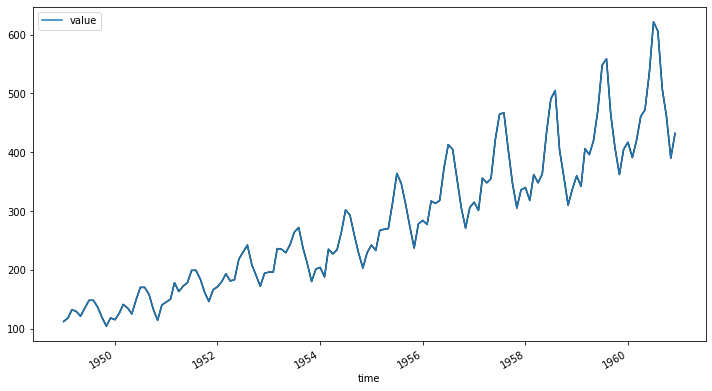

In [17]:
%matplotlib inline

# Must pass the name of the value columns to plot
air_passengers_ts.plot(cols=['value'])

## Utility functions

There are a number of useful utility functions Kats provides. These methods can be especially helpful when using your TimeSeriesData with external libraries. A few examples are included below.


### Convert to pandas.DataFrame

In [18]:
air_passengers_ts.to_dataframe().head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Convert to numpy.ndarray

In [19]:
air_passengers_ts.to_array()[0:5]

array([[Timestamp('1949-01-01 00:00:00'), 112],
       [Timestamp('1949-02-01 00:00:00'), 118],
       [Timestamp('1949-03-01 00:00:00'), 132],
       [Timestamp('1949-04-01 00:00:00'), 129],
       [Timestamp('1949-05-01 00:00:00'), 121]], dtype=object)

### Check characteristics of the time series

In [20]:
air_passengers_ts.is_empty()

False

In [21]:
air_passengers_ts.is_univariate()

True

# 2. Forecasting with Kats

Forecasting is one of the fundamental domains in Kats, we currently have 10 base forecasting models: linear model, quadratic model, ARIMA, SARIMA, Holt-Winters, Prophet, AR-Net, LSTM, Theta, and VAR models. All models follows the `sklearn` model API. In Kats we create an instance of the model class and then call its fit and predict methods. Taking the most popular internal forecasting model, prophet, as an example, we demonstrate how to create and visualize the models.

## 2.1 An example with Prophet model

We will demonstrate how to use Prophet model to forecast with the `air_passengers` data set.      

In [22]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# the predict method returns a dataframe as follows
fcst.head()

In [ ]:
# visualize the results with uncertainty intervals
m.plot()

## 2.2 An example with Theta model

The theta method of Assimakopoulos and Nikolopoulos (2000) is a univariate forecasting method that decomposes the original timeseries into two different Theta-lines (the `Theta=0` (straight line) and `Theta=2` (double local curves)) and generates forecasts by extrapolating them individually and combining the results. Hyndman and Billah (2003) demonstrated that this is equivalent to simple exponential smoothing with drift. Prediction intervals are calculated using this underlying model.

The timeseries is tested for seasonality using the test outlined in Assimakopoulos and Nikolopoulos (2000). If deemed seasonal, the series is seasonally adjusted using a classical multiplicative decomposition before applying the theta method. The resulting forecasts are then reseasonalized.

This implementation in Kats is similar to the thetaf function in R.

In [ ]:
# import param and model from `kats.models.theta`
from kats.models.theta import ThetaModel, ThetaParams

# create ThetaParam with specifying seasonality param value
params = ThetaParams(m=12)

# create ThetaModel with given data and parameter class
m = ThetaModel(data=air_passengers_ts, params=params)

# call fit method to fit model
m.fit()

# call predict method to predict the next 15 steps
res = m.predict(steps=30, alpha=0.2)

# visualize the results
m.plot()

# 3. Detection with Kats

Detection is another fundamental domain in Kats, where we provided a set of models and algorithms to detect certain patterns in time series data, such as outliers/anomalies, change point (regressions), slow trend changes, etc.

## 3.1 What are the algorithms?

To detect a specific pattern, we provided different algorithms, which is summarized as follows.
- **Outlier**. This usually refers to a abnormal spike in a time series data, which can be detected with `OutlierDetector`
- **Change point (regression)**. This refers to a sudden change that the time series have different statistical properties before and after the change. We provided three major algorithms to detect such patterns:
    - CUSUM
    - Bayesian Online Change Point Detection (BOCPD)
    - Stat-sig
- **Trend change**. This refers to a slow trend change on the time series data, which can be detected with Mann-Kendall detection algorithm, `MKDetector`

In this tutorial, we will demonstrate the usage of two detectors: `OutlierDetector` and `CUSUM`, we will have a in-depth tutorial for all detection algorithms in Kats 20x series



## 3.2 An example with outlier detection method

Outliers in Time Series can cause a lot of issues in downstream processing. Therefore removing outliers is important in any time series analysis. In Kats we have implemented an outlier detection algorithm with following steps:

- We do a time series decomposition of the input time series with additive or multiplicative decomposition as specified
- We generate a residual time series by either removing only trend or both trend and seasonality based on the strength of the seasonality in the time series.
- We detect points in the residual which are outside 3 times the inter quartile range. We can tune the outlier detection to incorporate less or more outliers by tuning this parameter

In [ ]:
# deep copy the air_passenger_df 
air_passengers_outlier_df = air_passengers_df.copy(deep=True)

# manually add outlier on the date of '1950-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1950-12-01','value']*=5
# manually add outlier on the date of '1959-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1959-12-01', 'value']*=4

In [ ]:
# visualize the raw data
air_passengers_outlier_df.plot(x='time', y='value', figsize=(15,8))

In [ ]:
# transform the outlier data into `TimeSeriesData` Object
air_passengers_outlier_ts = TimeSeriesData(air_passengers_outlier_df)

In [ ]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(air_passengers_outlier_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

we can now take a look at the outliers that the algorithum has found

In [ ]:
ts_outlierDetection.outliers[0]

After detecting the outlier, we can now easily removal them from the data. Here we will explore two options: 
- **No Interpolation**: outlier data points will be replaced with **NaN** values
- **With Interpolation**: outlier data points will be replaced with **linear interploation** values

In [ ]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation

It is also convenient to compare the difference between the two options with visualization.

In [ ]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")

## 3.3 An example with CUSUM algorithm

Cusum is a method to detect an up/down shift of means in a time series. In Kats implementation, it has two main components:

- Locate the change point: The algorithm iteratively estimates the means before and after the change point and finds the change point maximizing/minimizing the cusum value until the change point has converged. The starting point for the change point is at the middle.
- Hypothesis testing: Conducting log likelihood ratio test where the null hypothesis has no change point with one mean and the alternative hypothesis has a change point with two means.

And here are a few things worth mentioning:
- We assume there is only one increase/decrease change point;
- We use Gaussian distribution as the underlying model to calculate the cusum value and conduct the hypothesis test;

In [ ]:
# import packages
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector

# synthesize data with simulation
np.random.seed(10)
df = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', '2019-03-01'),
        'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
        'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
    }
)

In [ ]:
# detect increase
timeseries = TimeSeriesData(
    df.loc[:,['time','increase']]
)
detector = CUSUMDetector(timeseries)

# run detector
change_points = detector.detector(change_directions=["increase"])

# plot the results
detector.plot(change_points)

In [ ]:
# detect decrease
timeseries = TimeSeriesData(
    df.loc[:,['time','decrease']]
)
detector = CUSUMDetector(timeseries)

# run detector
change_points = detector.detector(change_directions=["decrease"])

# plot the results
detector.plot(change_points)

# 4. Feature Extraction with Kats

In time series analysis, there is often the need for characterizing a time series using a set of meaningful features. Example features include strength of seasonality, strength of trend, spikiness, amount of level shift, presence of flat segments, ACF/PACF based features, linearity, Hurst exponent, ARCH statistic, etc. The features are usually used for identifying similar/outlying time series from a large number of samples. They also play a crucial role in many downstream projects, including 
- (1). “Meta-learning”, i.e., choosing the best forecasting model based on characteristics of the input time series 
- (2). Time series classification and clustering analysis
- (3). Nowcasting algorithms for better short-term forecasting

TSFeatures is the module in Kats which computes such features. A similar package is openly available in R (https://pkg.robjhyndman.com/tsfeatures/index.html). Our implementation follows the feature definitions in the R package.

Now we will use `air passenger` data set for demo.

In [ ]:
# Initiate feature extraction class
from kats.tsfeatures.tsfeatures import TsFeatures
tsFeatures = TsFeatures()

In [ ]:
features_air_passengers = TsFeatures().transform(air_passengers_ts)

In [ ]:
# features_air_passengers
features_air_passengers

# 5. Summary

in this tutorial, we have shown the basic operations of **Kats** in time series application, including basic data structure, forecasting, detection, feature extraction, and utilities. 

If you want to explore more functions of **Kats**, you can check out Kats 20x tutorials:

- [Kats 201 Detection algorithms in Kats]
- [Kats 202 Forecasting with Kats]
- [Kats 203 How to tune params with Kats?]
- [Kats 204 Meta-learning for model selection and param tuning]